In [26]:
import rioxarray as rix
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import shape
from shapely.ops import unary_union
import geopandas as gpd
import numpy as np
import xarray as xr
import glob as glob

# Load vector data

In [27]:
def open_and_extract_date_from_filename(filepath):
    ds = rix.open_rasterio(filepath)
    ds.attrs['original_filename'] = os.path.basename(filepath)
    ds.attrs['date'] = os.path.basename(filepath)[:10]
    return ds

img_2023 = open_and_extract_date_from_filename("/Users/elischwat/Development/data/sublimationofsnow/planet_imagery/gothic-co-meltout-2023_psscene_analytic_sr_udm2/2023-05-16_strip_6512704_composite_file_format.tif")

<Axes: >

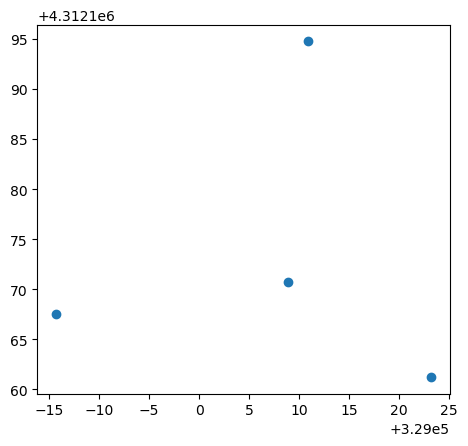

In [28]:
towers_gdf = gpd.read_file("./landsat_data/towers.geojson").to_crs(img_2023.rio.crs)
towers_gdf.plot()

In [29]:
central_point = towers_gdf.set_index('Tower').loc['c'].geometry
from shapely.geometry import box
x, y = central_point.x, central_point.y
bounding_box = gpd.GeoDataFrame(
    geometry = [box(x - 150, y - 150, x + 150, y + 150)],
)
bounding_box

,geometry
0,"POLYGON ((329158.911 4312020.778, 329158.911 4..."


In [30]:
lidar_l2 = rix.open_rasterio("lidar_data/l2_elevation_20230515_0000.tif")
lidar_l6 = rix.open_rasterio("lidar_data/l6_elevation_20230515_0000.tif")

<Axes: >

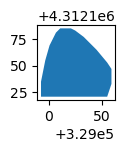

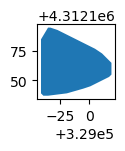

In [31]:
src_raster = lidar_l2.sel(band=1).astype('float32').rio.reproject(
    lidar_l2.rio.crs,
    resolution = (2,2)
)
src_raster.rio.to_raster('l2.tif')

src_raster = lidar_l6.sel(band=1).astype('float32').rio.reproject(
    lidar_l6.rio.crs,
    resolution = (2,2)
)
src_raster.rio.to_raster('l6.tif')


import rasterio
from rasterio.features import shapes
from shapely.geometry import shape

from geopandas import GeoDataFrame
from pandas import DataFrame


with rasterio.open('l2.tif') as src:
    data_l2 = src.read(1, masked=True)
    # Use a generator instead of a list
    shape_gen_l2 = ((shape(s), v) for s, v in shapes(data_l2, transform=src.transform))
    # or build a dict from unpacked shapes
    gdf_l2 = GeoDataFrame(dict(zip(["geometry", "class"], zip(*shape_gen_l2))), crs=src.crs)

# # Step 3: Perform a union on all geometries
union_geometry_l2 = unary_union(gdf_l2.geometry)
# # Step 4: Extract the convex hull
convex_hull_l2 = union_geometry_l2.convex_hull

with rasterio.open('l6.tif') as src:
    data_l6 = src.read(1, masked=True)
    # Use a generator instead of a list
    shape_gen_l6 = ((shape(s), v) for s, v in shapes(data_l6, transform=src.transform))
    # or build a dict from unpacked shapes
    gdf_l6 = GeoDataFrame(dict(zip(["geometry", "class"], zip(*shape_gen_l6))), crs=src.crs)

# # Step 3: Perform a union on all geometries
union_geometry_l6 = unary_union(gdf_l6.geometry)
# # Step 4: Extract the convex hull
convex_hull_l6 = union_geometry_l6.convex_hull

lidar_outline_gdf_l2 = gpd.GeoDataFrame(geometry=[convex_hull_l2])
lidar_outline_gdf_l2.plot(figsize=(1,1))
lidar_outline_gdf_l6 = gpd.GeoDataFrame(geometry=[convex_hull_l6])
lidar_outline_gdf_l6.plot(figsize=(1,1))

<Axes: >

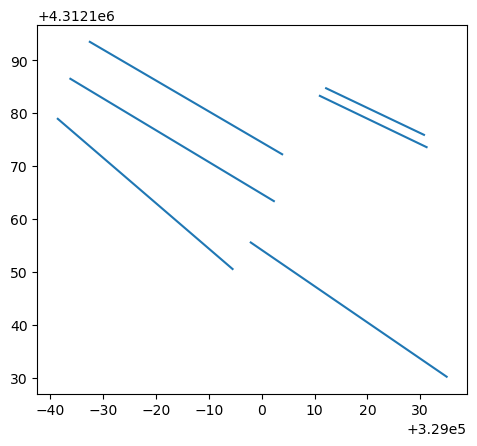

In [32]:
profile_lines_fn = "/Users/elischwat/Downloads/snow_patch_profiles.shp"
profile_lines_gdf = gpd.read_file(profile_lines_fn)
profile_lines_gdf = profile_lines_gdf.iloc[[0, 1, 2, 4, 5, 8]] # the ones we use for analysis in extract_e_melt.ipynb
profile_lines_gdf.plot()

# Plot for 2023

In [33]:
base_dir = "/Users/elischwat/Development/data/sublimationofsnow/planet_imagery/gothic-co-meltout-2023_psscene_analytic_sr_udm2/"
img_ls_2023 = [
    '2023-05-09_strip_6495899_composite_file_format.tif',
    '2023-05-10_strip_6497912_composite_file_format.tif',
    '2023-05-13_strip_6505736_composite_file_format.tif',
    '2023-05-15_strip_6510381_composite_file_format.tif',
    '2023-05-16_strip_6512704_composite_file_format.tif',
    '2023-05-23_strip_6528815_composite_file_format.tif',
]
img_ls_2023 = [open_and_extract_date_from_filename(os.path.join(base_dir, f)) for f in img_ls_2023]

In [34]:
# Crop all images
cropped_images = [(img.rio.clip(bounding_box.geometry)) for img in img_ls_2023]

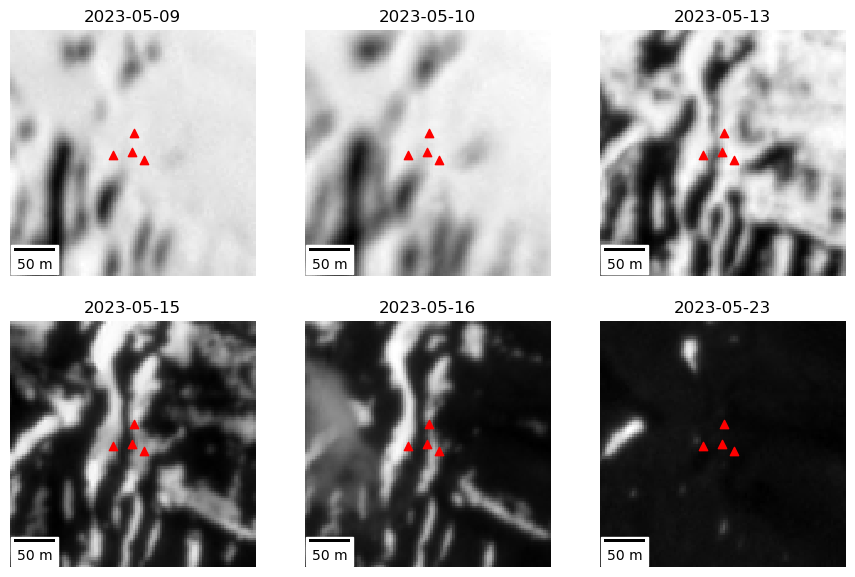

In [35]:
# Plot the images in a 3x2 grid
fig, axes = plt.subplots(2, 3, figsize=(9, 6))
axes = axes.flatten()

for ax, (cropped_img) in zip(axes, cropped_images):
    cropped_img.sel(band=1).plot(ax=ax, cmap='grey', add_colorbar=False)
    ax.set_aspect('equal')
    ax.axis('off')  # Remove axis
    ax.set_title(cropped_img.attrs['date'])
    towers_gdf.plot(ax=ax, color='red', marker='^')
    scalebar = ScaleBar(1, location="lower left")
    ax.add_artist(scalebar)

plt.tight_layout()
plt.show()

In [36]:
def get_normed_rgb_img(ds):
    # Stack the RGB bands (e.g., bands 1, 2, and 3)
    rgb_image = np.stack([
        ds.sel(band=3),  # Red
        ds.sel(band=2),  # Green
        ds.sel(band=1)   # Blue
    ], axis=-1)

    # Normalize the RGB image to [0, 1] for display
    rgb_image = rgb_image / rgb_image.max()

    # Convert the RGB image to an xarray dataset
    rgb_ds = xr.Dataset(
        {
            "red": (["y", "x"], rgb_image[..., 0]),
            "green": (["y", "x"], rgb_image[..., 1]),
            "blue": (["y", "x"], rgb_image[..., 2]),
        },
        coords={
            "y": ds["y"],
            "x": ds["x"]
        }
    )
    return rgb_ds

rgb_img_ls_2023 = [get_normed_rgb_img(img.rio.clip(bounding_box.geometry)) for img in img_ls_2023]

for old_img, new_img in zip(img_ls_2023, rgb_img_ls_2023):
    new_img.attrs = old_img.attrs

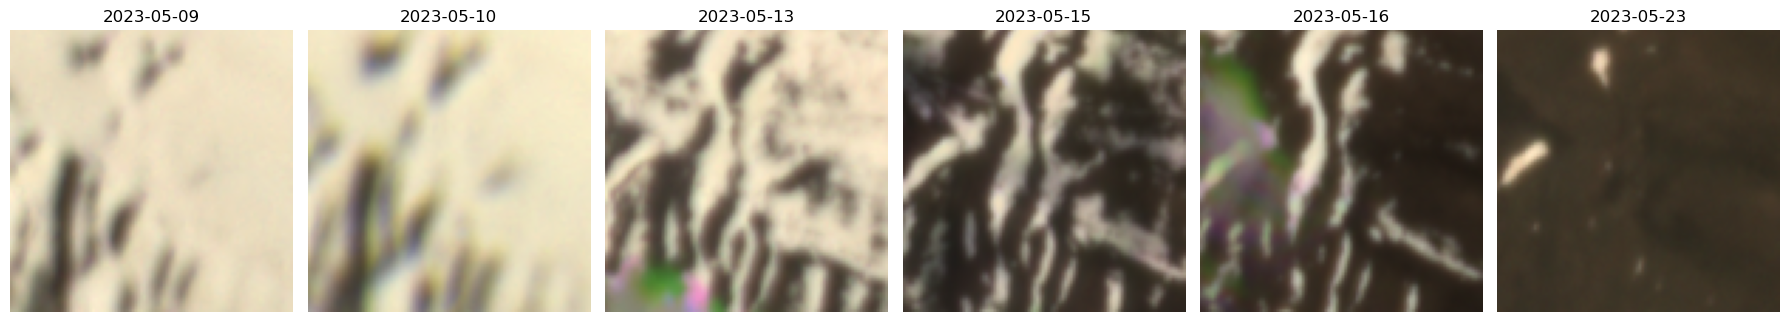

In [47]:

# Plot the images in a 3x2 grid
fig, axes = plt.subplots(1, 6, figsize=(18, 6))
axes = axes.flatten()

for ax, (cropped_img) in zip(axes, rgb_img_ls_2023):
    rgb_image_array = np.dstack((cropped_img['red'].values, cropped_img['green'].values, cropped_img['blue'].values))
    ax.imshow(rgb_image_array)
    ax.set_aspect('equal')
    ax.axis('off')  # Remove axis
    ax.set_title(cropped_img.attrs['date'])
    # towers_gdf.plot(ax=ax, color='red', marker='^')
    # scalebar = ScaleBar(1, location="lower left")
    # ax.add_artist(scalebar)

plt.tight_layout()
plt.show()

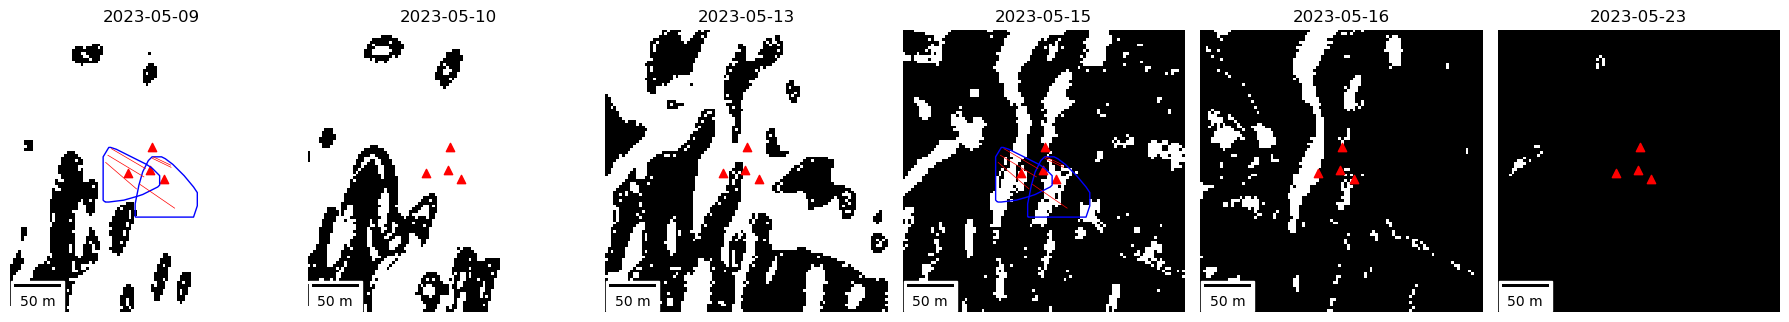

In [46]:
sca_imgs_2023 = sorted(glob.glob("./planet_data/SCA/*2023*.tif"))

fig, axes = plt.subplots(1, 6, figsize=(18, 6))
axes = axes.flatten()
for ax, (fn) in zip(axes, sca_imgs_2023):
    ds = open_and_extract_date_from_filename(fn)
    img = ds.plot(ax=ax, cmap='grey', add_colorbar=False)
    ax.set_aspect('equal')
    ax.axis('off')  # Remove axis
    ax.set_title(ds.attrs['date'])
    towers_gdf.plot(ax=ax, color='red', marker='^')
    scalebar = ScaleBar(1, location="lower left")
    ax.add_artist(scalebar)

lidar_outline_gdf_l2.plot(ax=axes[0], figsize=(1,1), alpha =1.0, edgecolor='blue', facecolor='none')
lidar_outline_gdf_l6.plot(ax=axes[0], figsize=(1,1), alpha =1.0, edgecolor='blue', facecolor='none')
profile_lines_gdf.plot(ax=axes[0], figsize=(1,1), alpha =1.0, edgecolor='red', facecolor='none', linewidth=0.5)

lidar_outline_gdf_l2.plot(ax=axes[3], figsize=(1,1), alpha =1.0, edgecolor='blue', facecolor='none')
lidar_outline_gdf_l6.plot(ax=axes[3], figsize=(1,1), alpha =1.0, edgecolor='blue', facecolor='none')
profile_lines_gdf.plot(ax=axes[3], figsize=(1,1), alpha =1.0, edgecolor='red', facecolor='none', linewidth=0.5)

plt.tight_layout()
plt.show()

# Plot for 2020-2025

In [39]:
ls planet_data/clipped

2020-05-02_strip_3365031_composite_file_format.tif
2021-04-29_strip_4427235_composite_file_format.tif
2022-05-06_strip_5620141_composite_file_format.tif
2023-05-09_strip_6495899_composite_file_format.tif
2023-05-10_strip_6497912_composite_file_format.tif
2023-05-13_strip_6505736_composite_file_format.tif
2023-05-15_strip_6510381_composite_file_format.tif
2023-05-16_strip_6512704_composite_file_format.tif
2023-05-23_strip_6528815_composite_file_format.tif
2024-05-02_strip_7279988_composite_file_format.tif
2025-04-25_strip_8025643_composite_file_format.tif


In [40]:
img_ls_2020_to_2025 = [
    "./planet_data/clipped/2020-05-02_strip_3365031_composite_file_format.tif", 
    "./planet_data/clipped/2021-04-29_strip_4427235_composite_file_format.tif", 
    "./planet_data/clipped/2022-05-06_strip_5620141_composite_file_format.tif", 
    "./planet_data/clipped/2023-05-16_strip_6512704_composite_file_format.tif", 
    "./planet_data/clipped/2024-05-02_strip_7279988_composite_file_format.tif", 
    "./planet_data/clipped/2025-04-25_strip_8025643_composite_file_format.tif", 
]
img_ls_2020_to_2025 = [open_and_extract_date_from_filename(f) for f in img_ls_2020_to_2025]

In [41]:
rgb_img_ls_2020_to_2025 = [get_normed_rgb_img(img.rio.clip(bounding_box.geometry)) for img in img_ls_2020_to_2025]

for old_img, new_img in zip(img_ls_2020_to_2025, rgb_img_ls_2020_to_2025):
    new_img.attrs = old_img.attrs

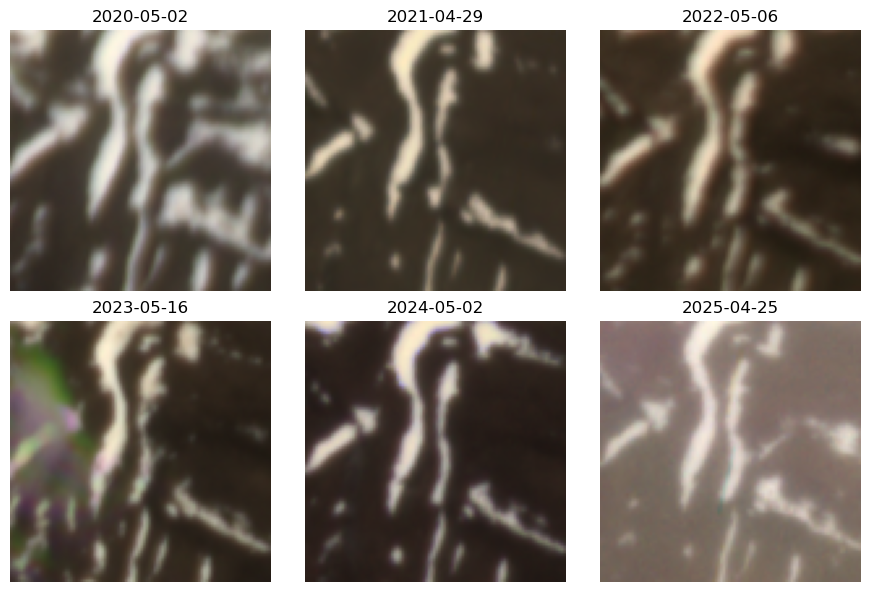

In [42]:

# Plot the images in a 3x2 grid
fig, axes = plt.subplots(2, 3, figsize=(9, 6))
axes = axes.flatten()

for ax, (cropped_img) in zip(axes, rgb_img_ls_2020_to_2025):
    rgb_image_array = np.dstack((cropped_img['red'].values, cropped_img['green'].values, cropped_img['blue'].values))
    ax.imshow(rgb_image_array)
    ax.set_aspect('equal')
    ax.axis('off')  # Remove axis
    ax.set_title(cropped_img.attrs['date'])
    # towers_gdf.plot(ax=ax, color='red', marker='^')
    # scalebar = ScaleBar(1, location="lower left")
    # ax.add_artist(scalebar)

plt.tight_layout()
plt.show()

In [43]:
sorted(glob.glob("./planet_data/SCA/*.tif"))[:3] + sorted(glob.glob("./planet_data/SCA/*.tif"))[7:8] + sorted(glob.glob("./planet_data/SCA/*.tif"))[9:]

['./planet_data/SCA/2020-05-02_strip_3365031_composite_file_format_SCA.tif',
 './planet_data/SCA/2021-04-29_strip_4427235_composite_file_format_SCA.tif',
 './planet_data/SCA/2022-05-06_strip_5620141_composite_file_format_SCA.tif',
 './planet_data/SCA/2023-05-15_strip_6510381_composite_file_format_SCA.tif',
 './planet_data/SCA/2023-05-23_strip_6528815_composite_file_format_SCA.tif',
 './planet_data/SCA/2024-05-02_strip_7279988_composite_file_format_SCA.tif',
 './planet_data/SCA/2025-04-25_strip_8025643_composite_file_format_SCA.tif']

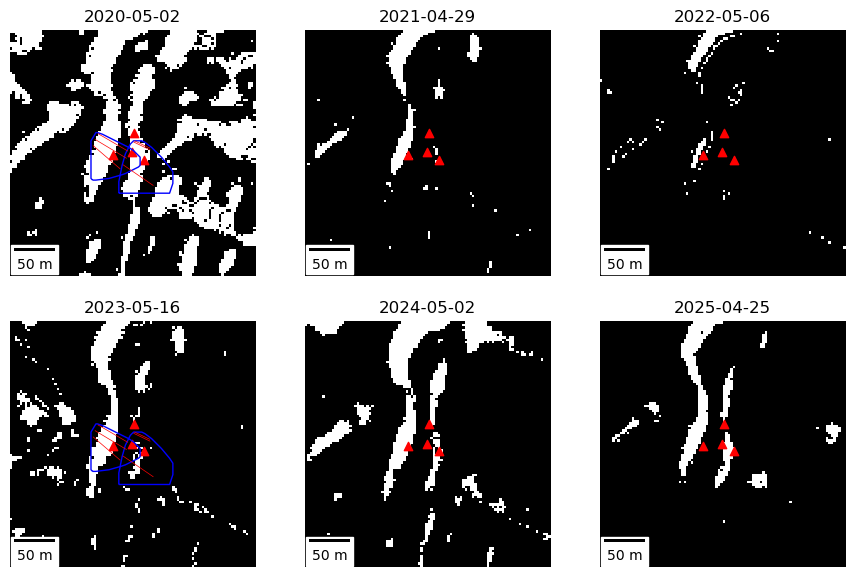

In [44]:
sca_imgs_2020_to_2025 = [
    './planet_data/SCA/2020-05-02_strip_3365031_composite_file_format_SCA.tif',
    './planet_data/SCA/2021-04-29_strip_4427235_composite_file_format_SCA.tif',
    './planet_data/SCA/2022-05-06_strip_5620141_composite_file_format_SCA.tif',
    './planet_data/SCA/2023-05-16_strip_6512704_composite_file_format_SCA.tif',
    './planet_data/SCA/2024-05-02_strip_7279988_composite_file_format_SCA.tif',
    './planet_data/SCA/2025-04-25_strip_8025643_composite_file_format_SCA.tif']

fig, axes = plt.subplots(2, 3, figsize=(9, 6))
axes = axes.flatten()
for ax, (fn) in zip(axes, sca_imgs_2020_to_2025):
    ds = open_and_extract_date_from_filename(fn)
    img = ds.plot(ax=ax, cmap='grey', add_colorbar=False)
    ax.set_aspect('equal')
    ax.axis('off')  # Remove axis
    ax.set_title(ds.attrs['date'])
    towers_gdf.plot(ax=ax, color='red', marker='^')
    scalebar = ScaleBar(1, location="lower left")
    ax.add_artist(scalebar)

lidar_outline_gdf_l2.plot(ax=axes[0], figsize=(1,1), alpha =1.0, edgecolor='blue', facecolor='none')
lidar_outline_gdf_l6.plot(ax=axes[0], figsize=(1,1), alpha =1.0, edgecolor='blue', facecolor='none')
profile_lines_gdf.plot(ax=axes[0], figsize=(1,1), alpha =1.0, edgecolor='red', facecolor='none', linewidth=0.5)

lidar_outline_gdf_l2.plot(ax=axes[3], figsize=(1,1), alpha =1.0, edgecolor='blue', facecolor='none')
lidar_outline_gdf_l6.plot(ax=axes[3], figsize=(1,1), alpha =1.0, edgecolor='blue', facecolor='none')
profile_lines_gdf.plot(ax=axes[3], figsize=(1,1), alpha =1.0, edgecolor='red', facecolor='none', linewidth=0.5)

plt.tight_layout()
plt.show()